In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
from pathlib import Path
import numpy as np
import polars as pl

root_dir = Path.cwd().parents[1]
if not root_dir in sys.path:
    sys.path.insert(0, str(root_dir))
# print(root_dir)

from inference.BayesModel import (
    BayesModel,
    # run_sampling,
    # get_mean_from_sampler,
    build_distr_structure_from_params,
)
from inference.HierarchicalBayesModel import prior_structure, norm_ppf, halfnorm_ppf
from inference.HierarchicalBayesModel.NestedSamplingMethods import run_sampling


df = pl.read_csv('../../../data/Treue/pone.0146500.s015.csv')
# df = pl.read_csv("../../../data/Treue/pone.0146500.s016.csv")

# Plan

- [x] assign unique (integer) IDs to cells (cellId + channelId)
- [ ] rewrite df into using IDs
- [ ] go through trials one by one
- [ ] assign offset angles to each neuron and trial:
    * start with first neuron and assign offset = 0 (thus angle = trial angle)
    * assign offset to other neurons in trial by trial angle - neuron angle
    * check for consistency (if broken, method doesn"t work!)

# result:
- neuron dictionary containing offset angles
- trial dictionary containing true angles

[ ] reassign angle to each neuron, based on offset and do analysis with these!

In [2]:
unique_trials = sorted(df.select("trialNum").unique().to_series().to_list())

# angles_neurons = dict()
neurons = (
    df.group_by(["cellId", "channelId"])
    .agg(pl.col(["rate"]).count().alias("count"))
    .with_row_index()
)

df_trials = pl.DataFrame({"trialNum": unique_trials, "angle": np.nan})
df_neurons = pl.DataFrame({"index": neurons["index"], "offset_angle": np.nan})
# angles_trials = dict()

df_renormalized = df.with_columns(pl.lit(-1).alias("index"))
for row in neurons.iter_rows():
    df_renormalized = df_renormalized.with_columns(
        pl.when((pl.col("cellId") == row[1]) & (pl.col("channelId") == row[2]))
        .then(row[0])
        .otherwise(pl.col("index"))
        .alias("index")
    )
# df_renormalized


def wrap_degrees(angle, offset=0):
    # return (angle + 180) % 360 - 180
    return (angle + offset) % 360 - offset


for trial in unique_trials:
    """
    * get trial angle
            * in first trial: just pick first neuron and assing trial angle = neuron angle
            * otherwise: calculate trial angle from already assigned dPhi
    * calculate dPhi of all neurons from it
    * check vs already assigned dPhi (should be consistent)
    * assign not yet assigned
    """
    this_trial = df_renormalized.filter(pl.col("trialNum") == trial)
    # print(this_trial)

    if start:
        idx_neuron, angle = df_trial.select(pl.first("index", "angle"))

        offset_angles = df_trial.select(pl.col("angle")) - angle
        print(offset_angles)
        for row in df_trial.iter_rows():
            print("row:", row)
            # neurons = neurons.with_columns(
            #     pl.when(
            #         (pl.col("index") == row[0])
            #     ).then(row[1]).otherwise(pl.lit(-1)).alias(f"angle_offset_{trial}")
            # )

        neurons = neurons.with_columns(
            pl.when((pl.col("index") == idx_neuron[0]))
            .then(0)
            .otherwise(pl.lit(-1))
            .alias("angle_offset")
        )

        df_trials = df_trials.with_columns(
            pl.when((pl.col("trialNum") == trial))
            .then(angle[0])
            .otherwise(pl.lit(-1))
            .alias("angle")
        )

    ## set trial angle
    df_trials[trial - 1, "angle"] = trial_angle
    print(f"trial {trial}, angle {trial_angle}")

    offset_angles = this_trial.select(
        [pl.col("index"), wrap_degrees(trial_angle - pl.col("angle")).alias("dPhi")]
    ).sort("index")

    ## check if consistent
    existing_entries = offset_angles.filter(
        pl.col("index").is_in(oriented_neurons["index"])
    ).sort("index")

    print(
        "oriented neurons:",
        oriented_neurons.filter(pl.col("index").is_in(this_trial["index"])).select(
            ["index", "offset_angle"]
        ),
    )
    print("existing entries:", existing_entries)

    df_check = existing_entries.join(
        oriented_neurons,
        on="index",
        how="left",
        suffix="_existing",
    )
    df_check = df_check.with_columns(
        (pl.col("dPhi") == pl.col("offset_angle")).alias("check")
    )
    print("check existing entries:", df_check)

    ## add new
    new_entries = offset_angles.filter(
        ~pl.col("index").is_in(oriented_neurons["index"])
    ).sort("index")
    print("new entries:", new_entries)

    df_neurons = (
        df_neurons.join(
            new_entries.select(["index", "dPhi"]),
            on="index",
            how="left",
        )
        .with_columns(
            pl.coalesce([pl.col("dPhi"), pl.col("offset_angle")]).alias("offset_angle")
        )
        .drop("dPhi")
    )

    if trial > 3:
        break

# print(angles_neurons)
# print(angles_trials)
neurons.filter(pl.col("angle_offset") != -1)
df_trials  # .filter(pl.col("angle") != -1)

NameError: name 'start' is not defined

In [3]:
group_size = df.group_by(["cellId", "channelId", "acond", "angle"]).agg(
    pl.col("rate").count().alias("count")
)
# print(f"Number of entries in group: {group_size}")
group_size

shape: (3_636, 5)
┌──────────────────────────┬───────────┬───────┬───────┬───────┐
│ cellId                   ┆ channelId ┆ acond ┆ angle ┆ count │
│ ---                      ┆ ---       ┆ ---   ┆ ---   ┆ ---   │
│ str                      ┆ i64       ┆ str   ┆ f64   ┆ u32   │
╞══════════════════════════╪═══════════╪═══════╪═══════╪═══════╡
│ vlk-rTask2-har-103-01+01 ┆ 1         ┆ ain   ┆ 150.0 ┆ 8     │
│ vlk-rTask2-har-055-02+01 ┆ 2         ┆ ain   ┆ 240.0 ┆ 12    │
│ vlk-rTask3-cls-031-03+01 ┆ 1         ┆ ain   ┆ 0.0   ┆ 7     │
│ vlk-rTask2-har-103-01+01 ┆ 2         ┆ afix  ┆ 60.0  ┆ 6     │
│ vlk-rTask1-cls-040-01+01 ┆ 2         ┆ afix  ┆ 240.0 ┆ 5     │
│ …                        ┆ …         ┆ …     ┆ …     ┆ …     │
│ vlk-rTask2-har-051-02+01 ┆ 1         ┆ afix  ┆ 300.0 ┆ 4     │
│ vlk-rTask1-cls-030-02+01 ┆ 2         ┆ ain   ┆ 90.0  ┆ 10    │
│ vlk-rTask2-har-053-02+01 ┆ 1         ┆ afix  ┆ 330.0 ┆ 6     │
│ vlk-rTask1-har-107-01+01 ┆ 1         ┆ afix  ┆ 180.0 ┆ 5     │
│ vlk-rTask1-cls-045-01+01 ┆ 1         ┆ ain   ┆ 150.0 ┆ 11    │
└──────────────────────────┴───────────┴───────┴───────┴───────┘

In [7]:
unique_trials = sorted(df.select("trialNum").unique().to_series().to_list())
unique_angles = sorted(df.select("angle").unique().to_series().to_list())

# angles_neurons = dict()
neurons = (
    df.group_by(["cellId", "channelId"])
    .agg(pl.col(["rate"]).count().alias("count"))
    .with_row_index()
)

df_trials = pl.DataFrame({"trialNum": unique_trials, "angle": np.nan})
df_neurons = pl.DataFrame({"index": neurons["index"], "offset_angle": np.nan})

grouped_df = df.group_by(["cellId", "channelId", "acond", "angle"]).agg(
    pl.col("rate").mean().alias("rate")
)

In [ ]:
from inference.BayesModel import BayesModel
from inference.HierarchicalBayesModel import prior_structure, norm_ppf, halfnorm_ppf

mode = "uni2"  # one of ain afix uni2
# mode = "afix"  # one of ain afix uni2
# mode = "ain"  # one of ain afix uni2
T = 6

prior = {}
# prior["gamma_0"] = prior_structure(norm_ppf, mean=2.0, sigma=0.5)
prior["gamma_pop0"] = prior_structure(
    halfnorm_ppf,
    loc=1.0,
    # mean=prior_structure(halfnorm_ppf, loc=1.0, scale=0.5),
    scale=0.5,
    # shape=(),
    label="$\gamma_0$",
)
prior["delta_pop0"] = prior_structure(norm_ppf, mean=6.0, sigma=2.0, label="\\delta_0")
# prior["nu_max_0"] = prior_structure(norm_ppf, mean=50.0, sigma=10.0)
prior["nu_max_pop0"] = prior_structure(None, value=[35.0], label="$\\nu^{max}$")

res = {}

df_cond = grouped_df.filter(pl.col("acond") == mode)
for angle in unique_angles:
    spike_counts = (
        df_cond.filter(pl.col("angle") == angle)["rate"].to_numpy().astype(np.float64)
    )

    print("shape:", spike_counts.shape)
    HBI = BayesModel()
    HBI.prepare_data(spike_counts[np.newaxis, np.newaxis, :], T)
    HBI.set_priors(prior)

    my_prior_transform = HBI.set_prior_transform(vectorized=False)
    my_loglikelihood = HBI.set_logl(vectorized=False)

    results, sampler = run_sampling(
        my_prior_transform,
        my_loglikelihood,
        HBI.parameter_names_all,
        n_live=100,
        nP=1,
    )

    # mean = get_mean_from_sampler(sampler, BM.paramNames, mode="dynesty")
    # mean["nu_max_0"] = prior["nu_max_0"]["parameters"]["value"][0]

    # res[angle] = mean
    res[angle] = results

    # params = build_distr_structure_from_params(mean, BM.paramIn)
    # print(params)

shape: (85,)
Different values of kappa currently not possible - check what needs to be done!
shape: (85,)
Different values of kappa currently not possible - check what needs to be done!
shape: (85,)
Different values of kappa currently not possible - check what needs to be done!
shape: (85,)
Different values of kappa currently not possible - check what needs to be done!
shape: (85,)
Different values of kappa currently not possible - check what needs to be done!
shape: (85,)
Different values of kappa currently not possible - check what needs to be done!
shape: (85,)
Different values of kappa currently not possible - check what needs to be done!
shape: (85,)
Different values of kappa currently not possible - check what needs to be done!
shape: (85,)
Different values of kappa currently not possible - check what needs to be done!
shape: (85,)
Different values of kappa currently not possible - check what needs to be done!
shape: (85,)
Different values of kappa currently not possible - check 

In [ ]:
import dynesty

dynesty.__version__

'3.0.0'

In [ ]:
# df.filter(pl.col("trialNum") == 9).filter(
#     pl.col("acond") == "uni2"
# )  # .group_by(["cellId", "channelId", "acond"]).agg(pl.col("rate").mean().alias("mean"))

condition = "afix"
unique_angles = sorted(
    df.filter(pl.col("acond") == condition)
    .select("angle")
    .unique()
    .to_series()
    .to_list()
)
print(unique_angles)

n_neurons = (
    df.filter(pl.col("acond") == condition)
    .group_by(["cellId", "channelId"])
    .agg(pl.col("rate").count().alias("count"))
).shape[0]

event_count = np.zeros((len(unique_angles), n_neurons))
for i, angle in enumerate(unique_angles):
    event_count[i, :] = (
        df.filter(pl.col("acond") == condition)
        .filter(pl.col("angle") == angle)
        .group_by(["cellId", "channelId", "acond"])
        .agg(pl.col("rate").mean())["rate"]
    )  # .alias("mean"))

[0.0, 30.0, 60.0, 90.0, 120.0, 150.0, 180.0, 210.0, 240.0, 270.0, 300.0, 330.0]


In [51]:
event_count.shape

(12, 109)

In [10]:
# mode = "uni2"  # one of ain afix uni2
# mode = "afix"  # one of ain afix uni2
# mode = "ain"  # one of ain afix uni2
T = 6

# df = pl.read_csv('../../../data/Treue/pone.0146500.s015.csv')
df = pl.read_csv("../../../data/Treue/pone.0146500.s016.csv")
biological = False
# results = {}
results2 = {}

for condition in ["uni2", "afix", "ain"]:

    n_neurons = (
        df.filter(pl.col("acond") == condition)
        .group_by(["cellId", "channelId"])
        .agg(pl.col("rate").count().alias("count"))
    ).shape[0]

    event_count = np.zeros((len(unique_angles), n_neurons))
    for i, angle in enumerate(unique_angles):
        event_count[i, :] = (
            df.filter(pl.col("acond") == condition)
            .filter(pl.col("angle") == angle)
            .group_by(["cellId", "channelId", "acond"])
            .agg(pl.col("rate").mean())["rate"]
        )

    HBI = BayesModel()
    HBI.prepare_data(event_count[:, None, :], T)

    prior = {}
    if biological:
        prior["nu_bar_pop0"] = prior_structure(
            halfnorm_ppf, loc=0.01, scale=5.0, shape=(event_count.shape[0],)
        )
        prior["alpha_0_pop0"] = prior_structure(
            halfnorm_ppf, loc=0.0, scale=0.1, shape=(event_count.shape[0],)
        )
        prior["tau_I_pop0_s0"] = prior_structure(
            halfnorm_ppf,
            loc=0.0001,
            scale=0.05,
        )
    else:
        prior["gamma_pop0"] = prior_structure(
            halfnorm_ppf, loc=1.0, scale=0.5, shape=(event_count.shape[0],)
        )
        prior["delta_pop0"] = prior_structure(
            norm_ppf, mean=6.0, sigma=2.0, shape=(event_count.shape[0],)
        )
        # prior["nu_max_0"] = prior_structure(norm_ppf, mean=50.0, sigma=10.0)
        prior["nu_max_pop0"] = prior_structure(
            halfnorm_ppf,
            loc=0.0,
            scale=30.0,
        )

    HBI.set_priors(prior)
    my_prior_transform = HBI.set_prior_transform(vectorized=False)
    my_loglikelihood = HBI.set_logl(
        vectorized=False,
        biological=biological,
    )

    results2[condition], sampler = run_sampling(
        my_prior_transform,
        my_loglikelihood,
        HBI.parameter_names_all,
        n_live=100,
        nP=12,
        dlogz=0.1,
        show_status=True,
    )

Different values of kappa currently not possible - check what needs to be done!


6931it [02:34, 44.78it/s, +100 | bound: 303 | nc: 1 | ncall: 1042371 | eff(%):  0.675 | loglstar:   -inf < -1113.541 <    inf | logz: -1180.219 +/-  0.774 | dlogz:  0.001 >  0.100]


Different values of kappa currently not possible - check what needs to be done!


6300it [02:17, 45.97it/s, +100 | bound: 285 | nc: 1 | ncall: 950652 | eff(%):  0.673 | loglstar:   -inf < -1128.991 <    inf | logz: -1189.402 +/-  0.734 | dlogz:  0.001 >  0.100]


Different values of kappa currently not possible - check what needs to be done!


6455it [02:19, 46.33it/s, +100 | bound: 286 | nc: 1 | ncall: 962699 | eff(%):  0.681 | loglstar:   -inf < -1261.118 <    inf | logz: -1323.066 +/-  0.742 | dlogz:  0.001 >  0.100]


In [21]:
# p_test = np.random.rand(HBI.n_params)
# p_trafo = my_prior_transform(p_test)
# likely = my_loglikelihood(p_test)
# print(p_test, p_trafo, likely)
results_bio = results
sampler_bio = sampler
HBI_bio = HBI

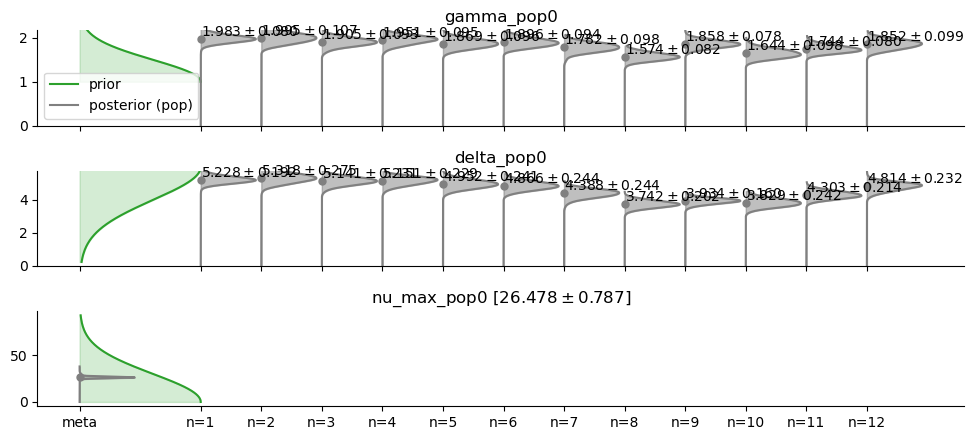

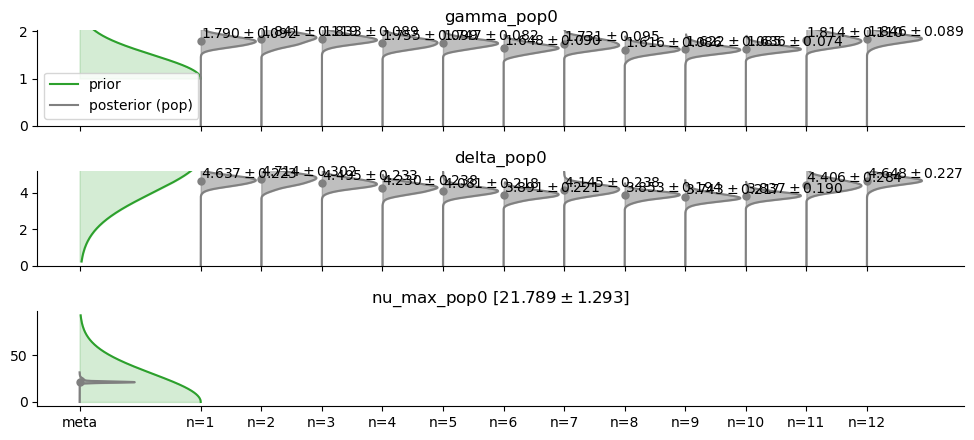

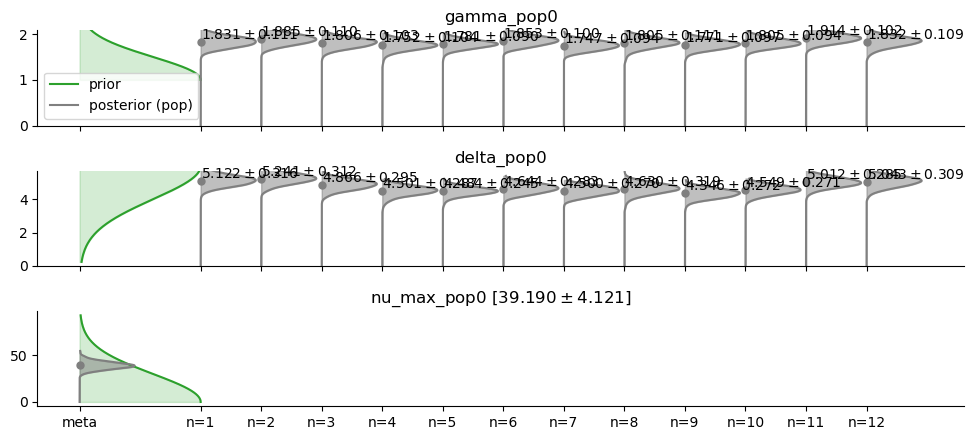

In [11]:
from inference.HierarchicalBayesModel.NestedSamplingMethods import plot_results

# %matplotlib ipympl

for condition in ["uni2", "afix", "ain"]:
    plot_results(HBI, results2[condition])

In [12]:
from inference.HierarchicalBayesModel.NestedSamplingMethods import (
    get_samples_from_results,
    get_posterior_from_samples,
)

samples = get_samples_from_results(results, mode="dynesty")
posterior = get_posterior_from_samples(
    samples["samples"],
    samples["weights"],
    HBI.parameter_names_all,
    x={
        "gamma": np.linspace(1, 3, 101),
        "delta": np.linspace(1, 8, 101),
        "nu_max": np.linspace(0, 100, 101),
    },
)
mean_list = [post["mean"] for post in posterior.values()]

IndexError: index 2 is out of bounds for axis 1 with size 2

In [ ]:
posterior["gamma_pop0_0"]["mean"]

np.float64(1.818362867083576)

## Make proper firing rate plot

In [13]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as sstats
from scipy.interpolate import make_interp_spline

from dynesty.plotting import _hist2d
from inference.BayesModel import distr_params
from inference.utils.utils import rho_nu

nu_array = np.linspace(0, 40, 501)


def plot_pdf(ax_pdf, df_cond, posterior, angles):

    ## empirical data
    if isinstance(angles[0], tuple):
        iterator = angles
    else:
        iterator = enumerate(angles)
    for i, angle in iterator:
        color = plt.cm.hsv(angle / 360.0)
        options = {
            "bins": np.linspace(0, 40, 51),
            # "label": f"angle {angle}",
            "histtype": "step",
            "color": color,
        }
        rates = df_cond.filter(pl.col("angle") == angle)["rate"].to_numpy() / 6.0

        params = distr_params(
            posterior[f"gamma_pop0_{i}"]["mean"],
            posterior[f"delta_pop0_{i}"]["mean"],
            posterior[f"nu_max_pop0"]["mean"],
        )

        nu_array = np.linspace(0, 40, 501)
        mask = nu_array < params.nu_max
        p_nu = rho_nu(nu_array[mask], params)
        ax_pdf.hist(rates, density=True, label="empirical", **options)
        ax_pdf.plot(nu_array[mask], p_nu, color=color, label="inferred")

        # break
    ax_pdf.legend()
    # ax_pdf.set_xscale("log")
    # ax_pdf.spines[["top", "right"]].set_visible(False)
    ax_pdf.spines[["top", "right"]].set_visible(False)
    plt.setp(ax_pdf, xlabel="rate [Hz]", ylabel="probability", yticks=[])


def plot_cdf(axes, df_cond, posterior, angles):

    ax_cdf, ax_diff = axes

    ## empirical data
    if isinstance(angles[0], tuple):
        iterator = angles
    else:
        iterator = enumerate(angles)
    for i, angle in iterator:
        color = plt.cm.hsv(angle / 360.0)
        rates = df_cond.filter(pl.col("angle") == angle)["rate"].to_numpy() / 6.0

        cdf = sstats.ecdf(rates)
        x = cdf.cdf.quantiles

        params = distr_params(
            posterior[f"gamma_pop0_{i}"]["mean"],
            posterior[f"delta_pop0_{i}"]["mean"],
            posterior[f"nu_max_pop0"]["mean"],
        )

        # nu_array = cdf.cdf.quantiles
        mask = nu_array < params.nu_max
        p_nu = rho_nu(nu_array[mask], params)
        # ax_pdf.plot(nu_array[mask], p_nu, label=f"Posterior {i}", color=color)

        cdf_nu = np.cumsum(p_nu) * (nu_array[1] - nu_array[0])
        cdf_interp = make_interp_spline(nu_array[mask], cdf_nu, k=3)

        mask = x < params.nu_max
        x = x[mask]
        # ax_cdf.plot(x, cdf_interp(x), color=color, lw=0.5)

        # ax_pdf.hist(rates, density=True, **options)
        ax_cdf.plot(x, cdf.cdf.probabilities[mask], color=color, lw=0.5)
        ax_cdf.fill_between(
            x, cdf.cdf.probabilities[mask], cdf_interp(x), color=color, alpha=0.4
        )
        ax_diff.plot(
            x, cdf.cdf.probabilities[mask] - cdf_interp(x), color=color, lw=0.5
        )

    ax_cdf.spines[["top", "right"]].set_visible(False)
    ax_diff.spines[["top", "right"]].set_visible(False)
    plt.setp(
        ax_cdf,
        xlabel="rate [Hz]",
        ylabel="Cumulative probability",
        ylim=(0, 1),
        # xlim=(0, ax_cdf.get_xlim()[1]),
        xlim=(0, 18),
    )
    plt.setp(ax_diff, ylabel="$\\Delta$ cdf")


def plot_posterior(ax, samples, angles):

    gamma_idx = HBI.priors["gamma_pop0"]["idx"]
    delta_idx = HBI.priors["delta_pop0"]["idx"]

    if isinstance(angles[0], tuple):
        iterator = angles
    else:
        iterator = enumerate(angles)
    for i, angle in iterator:
        color = plt.cm.hsv(angle / 360.0)
        _hist2d(
            samples["samples"][:, gamma_idx + i],
            samples["samples"][:, delta_idx + i],
            weights=samples["weights"],
            ax=ax,
            smooth=0.03,
            color=color,
            levels=[0.1, 0.3, 0.7, 0.9],
            contour_kwargs={"linewidths": [0.1, 0.5, 1, 2]},
        )

    import matplotlib.patches as mpatches
    from matplotlib.lines import Line2D

    # contour_patch = mpatches.Patch(color='tab:grey', label='posterior')
    patch = Line2D([0], [0], color="tab:grey", linewidth=1, linestyle="-")
    ax.legend([patch], ["posterior"])

    # ax.legend()
    plt.setp(
        ax,
        xlim=(1.5, 2.5),
        ylim=(3, 5),
        xticks=np.linspace(1.5, 2.5, 3),
        yticks=np.linspace(3, 5, 5),
        xlabel="$\\gamma$",
        ylabel="$\\delta$",
    )
    ax.spines[["top", "right"]].set_visible(False)


def plot_single_parameter_vs_angle(ax, values, unique_angles, **kwargs):

    colors = [plt.cm.hsv(angle / 360.0) for angle in unique_angles]

    ax.scatter(
        # np.radians(unique_angles),
        unique_angles,
        values,
        color=colors,
        cmap="hsv",
        marker="o",
        s=7,
        # norm=mpl.colors.Normalize(0, 2 * np.pi),
    )
    pref_angle = 240
    pref_idx = np.where(unique_angles == pref_angle)[0][0]

    ax.annotate(
        "",
        xy=(pref_angle, values[pref_idx] * 1.05),
        # xytext=(pref_angle, values[pref_idx]+1.),
        xytext=(201 / 300, 1.3),
        textcoords="axes fraction",
        arrowprops=dict(arrowstyle="->"),
    )

    plt.setp(
        ax, xticks=np.linspace(0, 360, 4), xlabel="direction $[^{\\circ}]$", **kwargs
    )
    ax.spines[["top", "right"]].set_visible(False)
    # ax_gamma.spines["polar"].set_visible(False)


def plot_colorwheel(ax_location):
    fig = plt.gcf()
    display_axes = fig.add_axes(ax_location, projection="polar")
    quant_steps = 256
    norm = mpl.colors.Normalize(0, 2 * np.pi)
    hsv = plt.cm.get_cmap("hsv", quant_steps)
    cmap = mpl.colors.ListedColormap(
        # hsv(np.tile(np.roll(np.linspace(0, 1.0, quant_steps), -int(quant_steps / 3)), 2))
        hsv(np.tile(np.roll(np.linspace(0, 1.0, quant_steps), -int(0 / 3)), 1))
    )

    cb = mpl.colorbar.ColorbarBase(
        display_axes, cmap=cmap, norm=norm, orientation="horizontal"
    )
    cb.outline.set_visible(False)

Condition: afix
Condition: uni2
Condition: ain


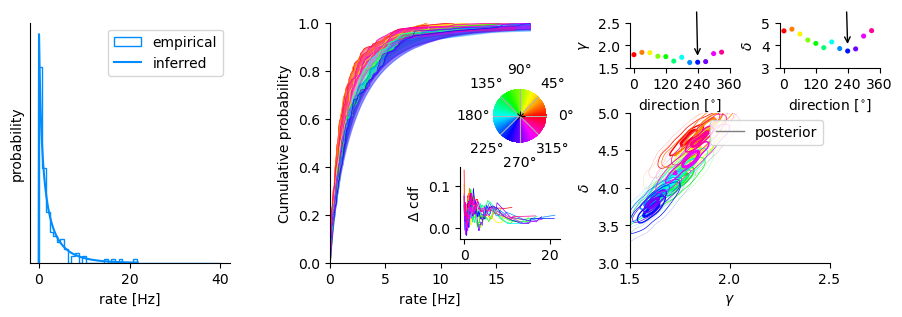

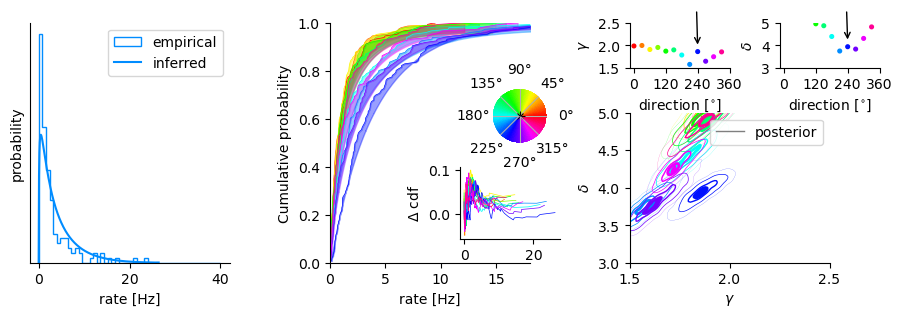

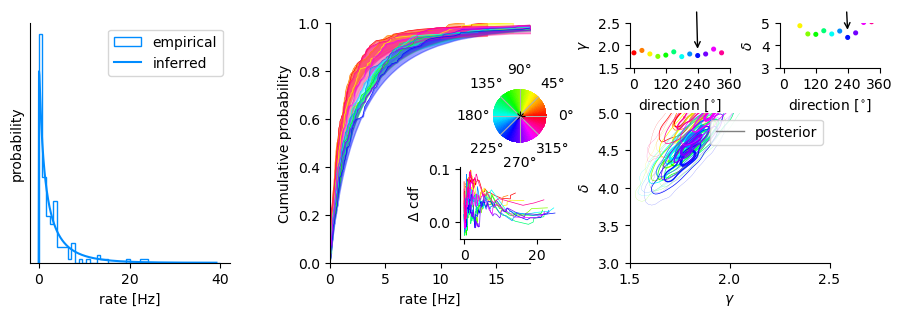

In [ ]:
# should include empirical data as well as resulting inferred shapes
import numpy as np

from inference.HierarchicalBayesModel.NestedSamplingMethods import (
    get_samples_from_results,
    get_posterior_from_samples,
)


# df = pl.read_csv('../../../data/Treue/pone.0146500.s015.csv')
df = pl.read_csv("../../../data/Treue/pone.0146500.s016.csv")
grouped_df = df.group_by(["cellId", "channelId", "acond", "angle"]).agg(
    pl.col("rate").mean().alias("rate")
)


# To filter all entries where the `angle` column equals a specific value (e.g., 240.0):
unique_conditions = grouped_df["acond"].unique()
unique_angles = grouped_df["angle"].unique()


# cond = "ain"
# print(f"Condition: {cond}")

for condition in unique_conditions:
    print(f"Condition: {condition}")

    ### preparing data
    samples = get_samples_from_results(results2[condition], mode="dynesty")
    # samples = get_samples_from_results(results2[condition], mode="dynesty")
    posterior = get_posterior_from_samples(
        samples["samples"],
        samples["weights"],
        HBI.parameter_names_all,
        x={
            "gamma": np.linspace(1, 3, 101),
            "delta": np.linspace(1, 8, 101),
            "nu_max": np.linspace(0, 100, 101),
        },
    )
    mean_list = [post["mean"] for post in posterior.values()]

    gamma_idx = HBI.priors["gamma_pop0"]["idx"]
    gamma_mean = mean_list[gamma_idx : gamma_idx + len(unique_angles)]
    delta_idx = HBI.priors["delta_pop0"]["idx"]
    delta_mean = mean_list[delta_idx : delta_idx + len(unique_angles)]

    df_cond = grouped_df.filter(pl.col("acond") == condition)

    ## setting up axes
    fig = plt.figure(figsize=(10, 3))
    ax_pdf = fig.add_axes([0.1, 0.15, 0.2, 0.8])
    ax_cdf = fig.add_axes([0.4, 0.15, 0.2, 0.8])
    ax_contours = fig.add_axes([0.7, 0.15, 0.2, 0.5])

    pos = ax_cdf.get_position()
    ax_diff = fig.add_axes(
        [
            pos.x0 + pos.width * 0.65,
            pos.y0 + pos.height * 0.1,
            pos.width * 0.5,
            pos.height * 0.3,
        ]
    )

    plot_pdf(ax_pdf, df_cond, posterior, [(8, 210.0)])
    plot_cdf((ax_cdf, ax_diff), df_cond, posterior, unique_angles)
    plot_posterior(ax_contours, samples, unique_angles)

    plot_colorwheel([0.5, 0.55, 0.18, 0.18])

    ax_gamma = fig.add_axes([0.7, 0.8, 0.1, 0.15])  # , projection="polar")
    plot_single_parameter_vs_angle(
        ax_gamma, gamma_mean, unique_angles, ylabel="$\\gamma$", ylim=(1.5, 2.5)
    )

    ax_delta = fig.add_axes([0.85, 0.8, 0.1, 0.15])  # , projection="polar")
    plot_single_parameter_vs_angle(
        ax_delta, delta_mean, unique_angles, ylabel="$\\delta$", ylim=(3, 5)
    )

    if i == 0:
        ax_cdf.legend(ncols=2, fontsize="small")
    # ax_pdf.set_title(f"condition {cond}")
    # break
    # plt.tight_layout()
    plt.savefig(f"Treue_inference_{condition}.png", dpi=300)

## Make proper posterior distribution plot

0 12


[1.5, 2.5, 3.0, 5.0, Text(0.5, 0, '$\\gamma$'), Text(0, 0.5, '$\\delta$')]

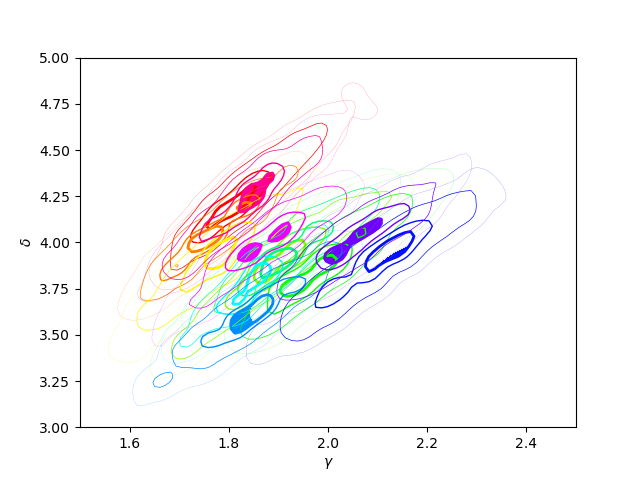

In [ ]:
# plt.close("all")
# print(samples)
# print(HBI.priors)


i = 0
print(gamma_idx, delta_idx)

# x = samples["samples"][:, gamma_idx+i]
# y = samples["samples"][:, delta_idx+i]
weights = samples["weights"]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for i, angle in enumerate(unique_angles):
    color = plt.cm.hsv(angle / 360.0)
    _hist2d(
        samples["samples"][:, gamma_idx + i],
        samples["samples"][:, delta_idx + i],
        weights=weights,
        ax=ax,
        smooth=0.03,
        color=color,
        levels=[0.1, 0.3, 0.7, 0.9],
        contour_kwargs={"linewidths": [0.1, 0.5, 1, 2]},
    )
plt.setp(ax, xlim=(1.5, 2.5), ylim=(3, 5), xlabel="$\\gamma$", ylabel="$\\delta$")

# plt.show()

## make proper overall results plot

(<Figure size 1600x1600 with 4 Axes>,
 array([<Axes: xlabel='$-\\ln X$', ylabel='Live Points'>,
        <Axes: xlabel='$-\\ln X$', ylabel='Likelihood\n(normalized)'>,
        <Axes: xlabel='$-\\ln X$', ylabel='Importance\nWeight PDF'>,
        <Axes: xlabel='$-\\ln X$', ylabel='Evidence'>], dtype=object))

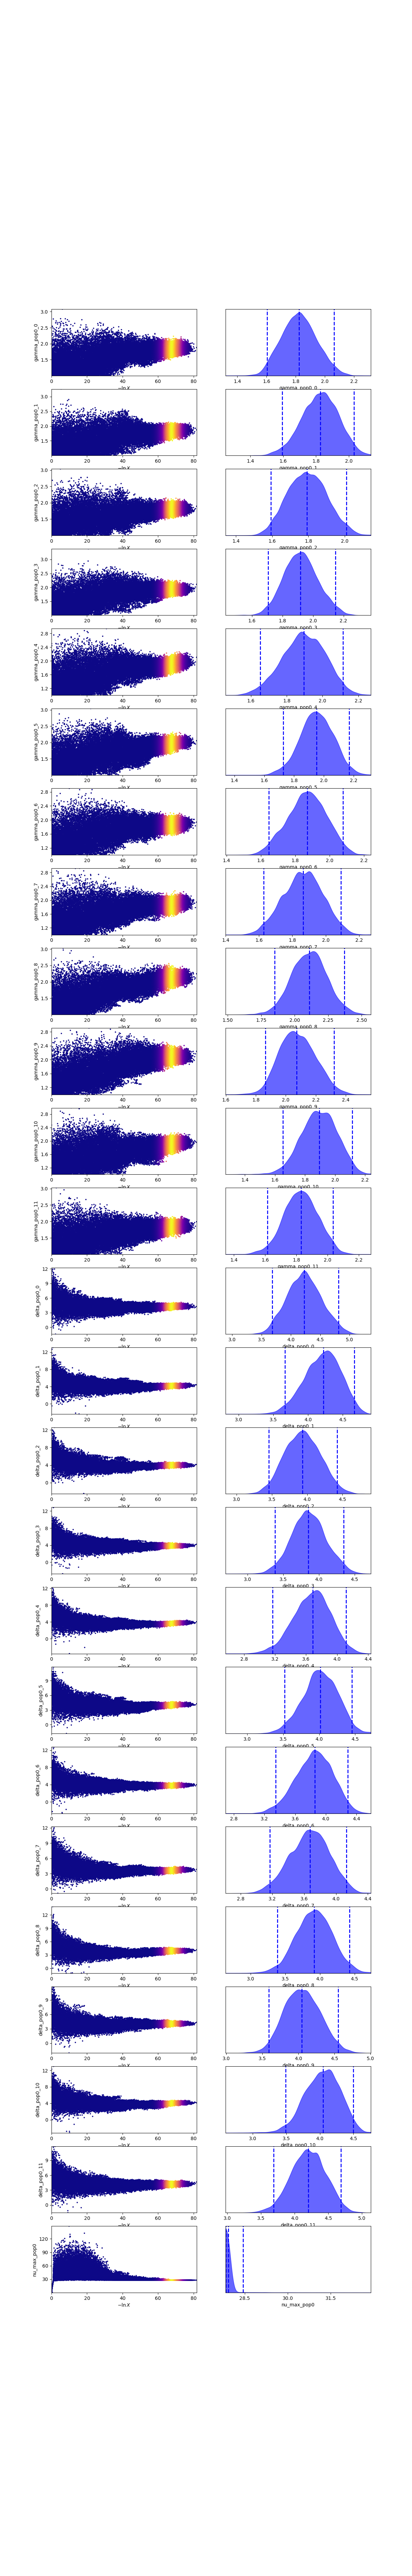

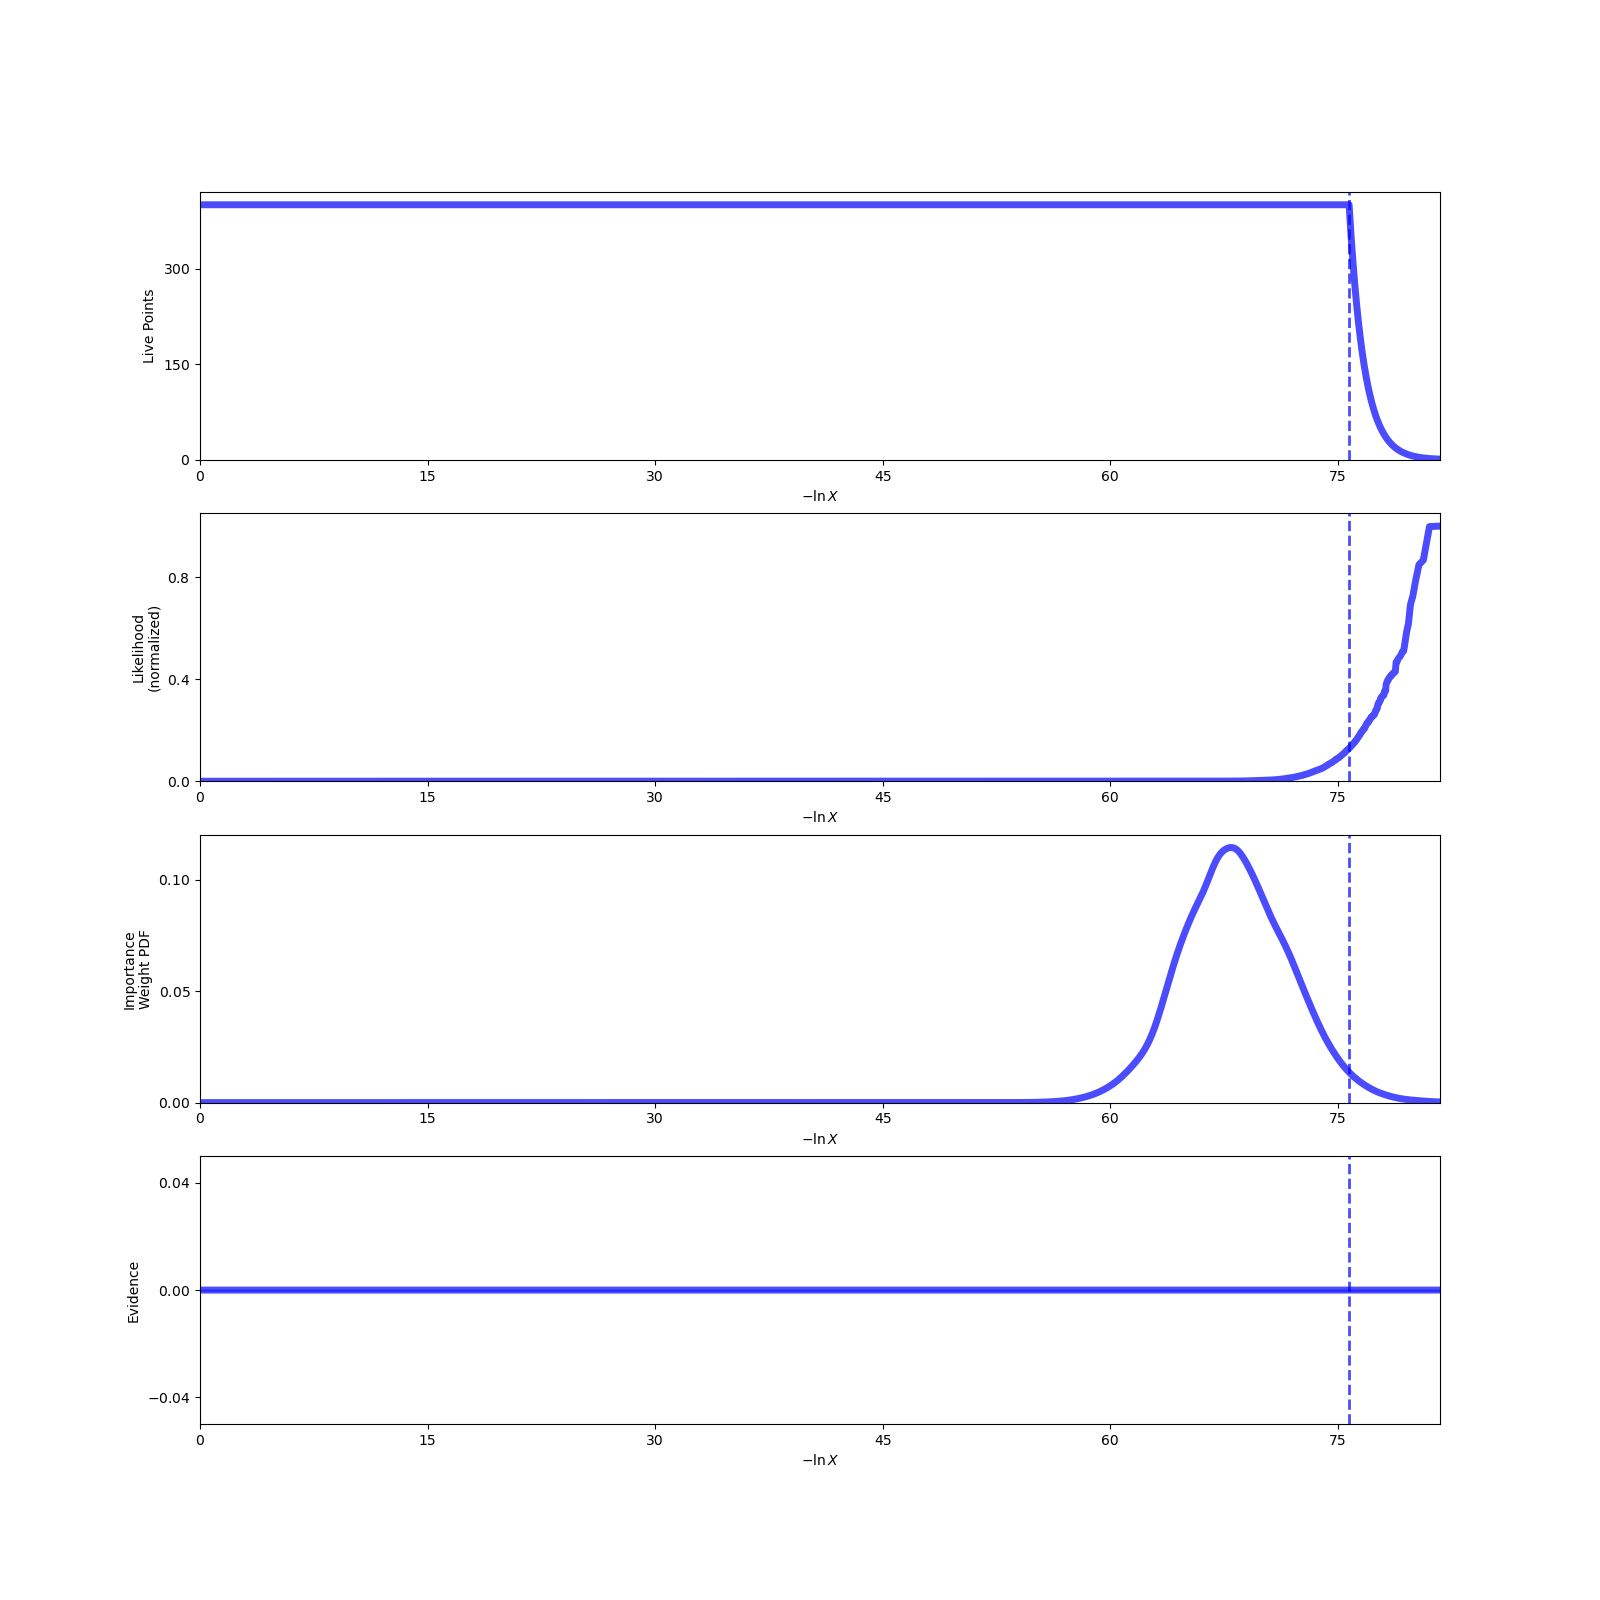

In [ ]:
import dynesty.plotting as dyplot

dyplot.traceplot(results, labels=HBI.parameter_names_all)
dyplot.runplot(results)

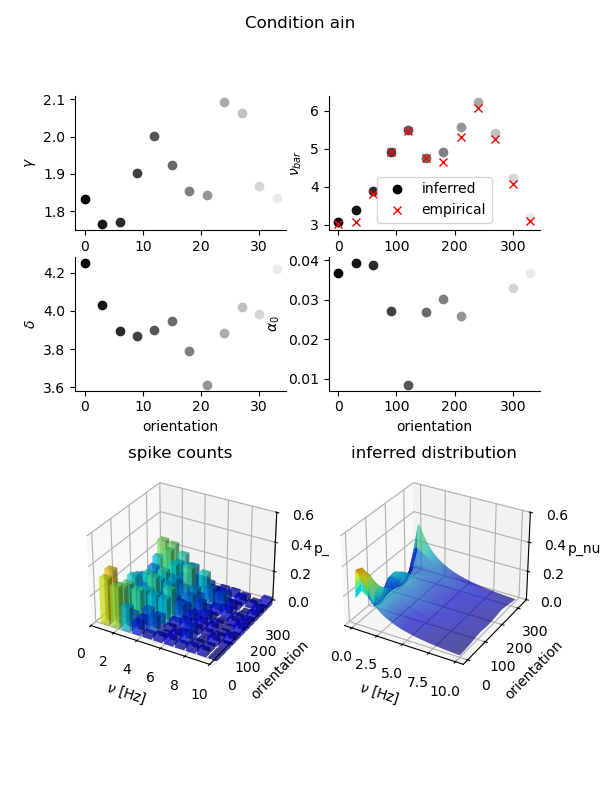

In [ ]:
from general.network import Network

from inference.utils.utils import rho_nu

from inference.transform_meta_to_bio import get_alpha_0, get_nu_bar
from matplotlib import cm
from matplotlib.colors import Normalize

%matplotlib ipympl

fig = plt.figure(figsize=(6,8))
ax_gamma = fig.add_subplot(421)
ax_delta = fig.add_subplot(423)
ax_nu_bar = fig.add_subplot(422)
ax_alpha_0 = fig.add_subplot(424)



nu_cut = 10.

# params = build_distr_structure_from_params(res[0], BM.paramIn)
nu_array = np.linspace(
    0,
    # params["distr"][0]["nu_max"],
	nu_cut,
    1001,
    # np.ceil(params["distr"][0]["nu_max"] * T + 1.0).astype(int),
)

nbins = 11
spike_count_hist = np.zeros((nbins, event_count.shape[0]))


x={
	"gamma": np.linspace(1, 4, 51),
	"delta": np.linspace(1, 8, 51),
	"nu_max": np.linspace(0, 100, 101),
}


p_nu_mesh = np.zeros((len(nu_array), event_count.shape[0]))
# pop_idx = 0
samples = get_samples_from_results(results, mode="dynesty")
posterior = get_posterior_from_samples(samples["samples"],samples["weights"],HBI.parameter_names_all,x=x)
mean_list = [post["mean"] for post in posterior.values()]


# for i, (angle, params) in enumerate(res.items()):
for i, angle in enumerate(unique_angles):

	# print(angle,params)

	color = plt.cm.grey(i / len(unique_angles))
	offset = angle/10

	params = HBI.get_params_from_p(np.array(mean_list),idx=(i,))

	ax_gamma.plot(offset, params["distr"][0].gamma, "o", color=color)

	ax_delta.plot(offset, params["distr"][0].delta, "o", color=color)


	p_nu_mesh[:, i] = rho_nu(nu_array, params["distr"][0])

	alpha_0 = get_alpha_0(params["distr"][0],nP=1)  # This will print the alpha_0 value
	nu_bar = get_nu_bar(params["distr"][0])  # This will print the nu
	# print(f"Angle {angle}: alpha_0 = {alpha_0}, nu_bar = {nu_bar}")

	ax_alpha_0.plot(angle, alpha_0, "o", color=color)
	ax_nu_bar.plot(angle, nu_bar, "o", color=color,label="inferred" if i==0 else None)

	spike_counts = (
		df_cond.filter(pl.col("angle") == angle)["rate"].to_numpy().astype(np.float64)
	)

	spike_count_hist[:,i], bin_edges = np.histogram(spike_counts / T, bins=nbins, range=(0, nu_cut), density=True)

	# Optionally, store or plot hist for each angle if needed
	nu_bar_emp = spike_counts.mean() / T
	ax_nu_bar.plot(angle, nu_bar_emp, "rx",label="empirical" if i==0 else None)#, color=color)

plt.setp(ax_gamma, xlabel="orientation", ylabel="$\gamma$")
plt.setp(ax_delta, xlabel="orientation", ylabel="$\delta$")
plt.setp(ax_nu_bar, xlabel="orientation", ylabel="$\\nu_{bar}$")
plt.setp(ax_alpha_0, xlabel="orientation", ylabel="$\\alpha_0$")
for axx in [ax_gamma, ax_delta, ax_nu_bar, ax_alpha_0]:
	axx.spines[["top", "right"]].set_visible(False)
ax_nu_bar.legend()

ax_spike_counts = fig.add_subplot(223,projection='3d')
ax_distr = fig.add_subplot(224,projection='3d')


# 3D histogram of spike counts for each angle
xpos, ypos = np.meshgrid(bin_edges[:-1] + (bin_edges[1] - bin_edges[0]) / 2, unique_angles)
xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros_like(xpos)

dx = (bin_edges[1] - bin_edges[0]) * 0.8
dy = (unique_angles[1] - unique_angles[0]) * 0.8 if len(unique_angles) > 1 else 1
dz = spike_count_hist.T.flatten()

# Normalize dz for coloring
norm_hist = Normalize(vmin=dz.min(), vmax=0.5)
colors_hist = cm.jet(norm_hist(dz))

ax_spike_counts.bar3d(xpos, ypos, zpos, dx, dy, dz, shade=True, alpha=0.5, color=colors_hist, zsort='average')

plt.setp(ax_spike_counts, xlabel='$\\nu$ [Hz]', ylabel='orientation', zlabel='p_nu', xlim=[0, nu_cut],zlim=[0,0.6])
ax_spike_counts.set_title("spike counts")

X, Y = np.meshgrid(nu_array, unique_angles)
Z = p_nu_mesh.T  # shape: (len(angle_array), len(nu_array))

# Normalize Z for coloring
norm = Normalize(vmin=Z[np.isfinite(Z)].min(), vmax=0.5)
face_colors = cm.jet(norm(Z))

Z[:,0] =np.nan

surf = ax_distr.plot_surface(X, Y, Z, 
	facecolors=face_colors,
    edgecolor='none', 
    rstride=1, cstride=1, 
    antialiased=True)
surf.set_alpha(1.0)
plt.setp(ax_distr, xlabel='$\\nu$ [Hz]', ylabel='orientation', zlabel='p_nu',zlim=[0,0.6])
ax_distr.set_title("inferred distribution")
plt.suptitle(f"Condition {mode}")
plt.savefig(f"TreueData_analysis_{mode}_015.png", dpi=300)
# plt.show()

(<Figure size 600x600 with 1 Axes>,
 <Axes: xlabel='gamma_pop0_0', ylabel='gamma_pop0_1'>)

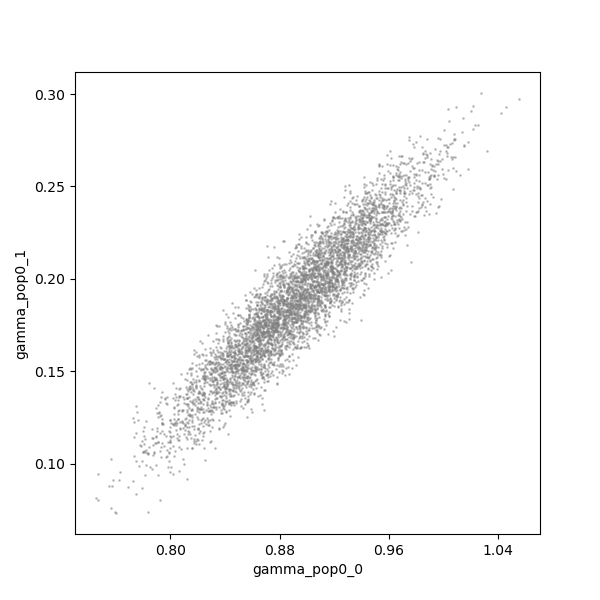

In [ ]:
from dynesty import plotting as dyplot

dyplot.traceplot(results, labels=HBI.parameter_names_all)
# dyplot.runplot(results)
# dyplot.cornerplot(results,labels=HBI.parameter_names_all)
# dyplot.cornerpoints(results,labels=HBI.parameter_names_all)
dyplot.boundplot(results, dims=(0, 12), it=6650, labels=HBI.parameter_names_all)

{'distr': [{'gamma': 1.5165431884263554, 'delta': 4.149551859722681, 'nu_max': 25.0}]}


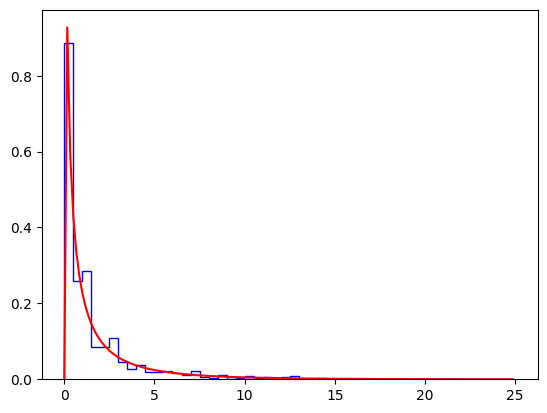

In [ ]:
mean["nu_max_0"] = prior["nu_max_0"]["parameters"]["value"][0]

plt.figure()
n_steps = 51
_ = plt.hist(
    spike_counts / 6,
    bins=np.linspace(0, mean["nu_max_0"], n_steps),
    histtype="step",
    label="angle 0",
    color="blue",
    density=True,
)

dnu = mean["nu_max_0"] / n_steps

params = build_distr_structure_from_params(mean, BM.paramIn)
print(params)

nu = np.linspace(0, mean["nu_max_0"], np.ceil(mean["nu_max_0"] * T + 1.0).astype(int))
plt.plot(nu, p_nu(nu, params), "r-", label="p_nu")


# from dynesty import utils as dyfunc, plotting as dyplot
# dyplot.cornerplot(
#     sampler.results,
#     color="dodgerblue",
#     # truths=truth_values,
#     show_titles=True,
# )
# plt.show(block=False)

In [ ]:
mode = "dynesty"
mean = {}
for i, key in enumerate(BM.paramNames):
    if mode == "dynesty":
        samp = sampler.results.samples[:, i]
        weights = sampler.results.importance_weights()
    else:
        samp = sampler.results["weighted_samples"]["points"][:, i]
        weights = sampler.results["weighted_samples"]["weights"]

    mean[key] = (samp * weights).sum()
    print(f"{key} mean: {mean[key]}")

gamma_0 mean: 1.5144112832857677
delta_0 mean: 4.185123503482691
nu_max_0 mean: 27.83969998051562


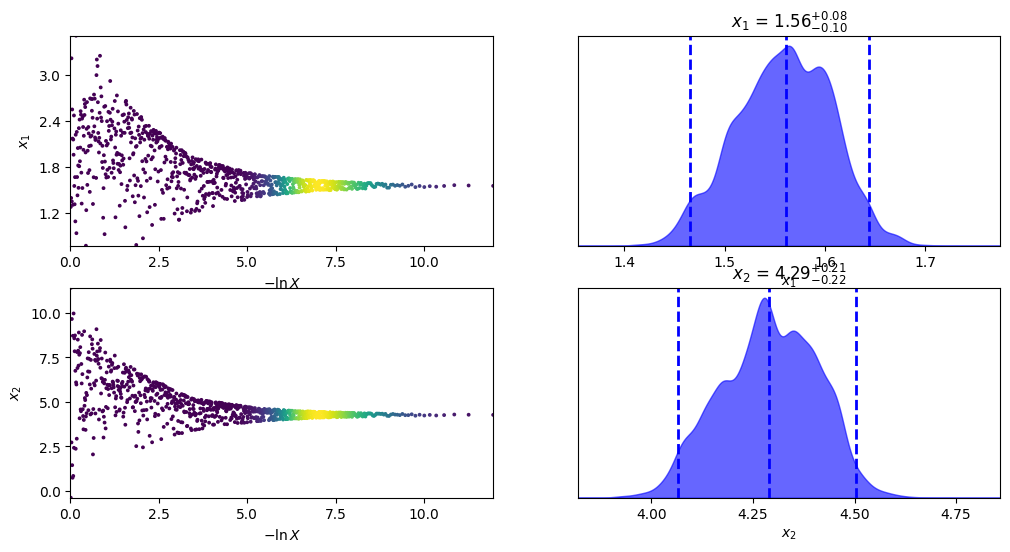

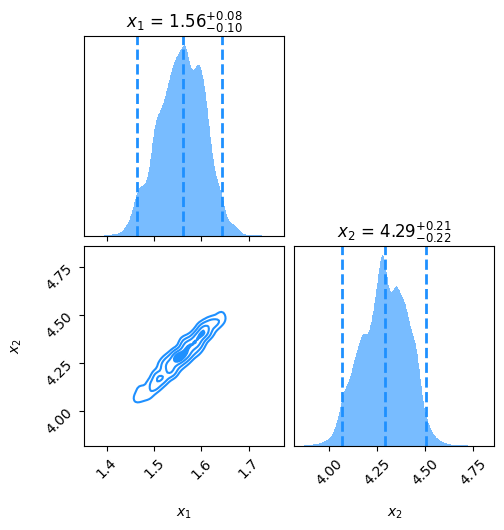

In [ ]:
dyplot.traceplot(
    sampler.results,
    # truths=truth_values,
    truth_color="black",
    show_titles=True,
    trace_cmap="viridis",
)
plt.show(block=False)
dyplot.cornerplot(
    sampler.results,
    color="dodgerblue",
    # truths=truth_values,
    show_titles=True,
)
plt.show(block=False)

In [58]:
BM.binom[0]["log_binomial_coefficient"][600]

835.575718826994

In [ ]:
from scipy.special import binom as sp_binom, comb
from scipy import special, exp, log

lgam = special.gammaln


def log_binomial(n, k):
    return lgam(n + 1) - lgam(n - k + 1) - lgam(k + 1)


# binom = sp_binom(BM.data['nNeurons'][0],np.arange(BM.data['nNeurons'][0]+1))
# binom = sp_binom(BM.data['nNeurons'][0],400)

binom = log_binomial(BM.data["nNeurons"][0], np.arange(10))
print(binom)

# binom = comb(BM.data['nNeurons'][0],400,exact=True)
# # print(np.log(binom))
# print(binom)
# binom[800:900]

[ 0.          7.09920174 13.5044302  19.50336676 25.21379378 30.70024909
 36.003554   41.15187869 46.16584178 51.06119092]


In [63]:
p_in = np.array([1.7, 3.9])

my_likelihood = BM.set_logl(
    vectorized=vectorized,
    correct_N=0,
    bias_to_expected_max=0,
    bias_to_mean=0,
    biological=False,
)
my_likelihood(p_in)

-1181.8931599756434